In [1]:
import numpy as np
from pc_kriging import PC_Kriging
import matplotlib.pyplot as plt
from scipy.stats import norm
from doepy import build
from scipy import optimize
import pandas as pd
from numpy import genfromtxt
import pickle

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

def U_function(u, v):
    return np.abs(u)/v

def LinearNorm(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))

# def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [1D array]
#     dist=abs(distance(x,xn))
#     voro=np.argmin(np.squeeze(dist))
#     return voro

In [2]:
# #ground truth function----------------------------------------------------
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

Creating object

In [3]:
config = {"pol_type": ['hermite', 'hermite']}   #design variables following normal distribution
PCK1 = PC_Kriging(config)

DoE and model evaluations

In [92]:
#definition of input parameters----------------------------------------------

function = gfun_53   #choose the ground truth function

dim=2       # dimensionality
n=40        # number of initial sampling
seed=0      # fixing seed random number generator

np.random.seed(seed)         #fixing seed random number generator

#------------------------------------------------------------
xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
yn = np.zeros((int(n)))           #observations
#------------------------------------------------------------
#initial design of experiments (LHS) --------------------------------
x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

Xdoe=build.space_filling_lhs({'x1':[-2, 2], 
                              'x2':[-2, 2],}, 
                              num_samples = n )
#------------------------------------------------------------
xn[:,0] = Xdoe['x1']
xn[:,1] = Xdoe['x2']
xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

g_val_sys= function(xr)
yn=g_val_sys[0]

In [94]:
dist = PCK1.distance(xn, xn)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
lmin

0.1450475448587791

In [97]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
l= 1.27   #length scale
v= 5/2    #matern coefficient
theta= np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1= PCK1.train (xn,yn,p,theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2,

(array([ 1.64892214, -0.37846183, -0.06956297,  0.15374398, -0.14589777,
        -0.35142329]),
 1.0644113110030018)

In [96]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))
    
results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


([(0.1450475448587791, 4.984657591886305)],
 array([1.27386292]),
 array([1.27384838]),
 array([1.27376215]))

In [101]:
# model predictions -----------------------------------------

ntest=600  # test points
seed=0      # fixing seed random number generator
np.random.seed(seed)         #fixing seed random number generator

# test points -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

G_VAL_SYS= function(XR)
YN=G_VAL_SYS[0]

mean1,var1 = PCK1.predict(XN)

mse = np.mean ((YN - mean1)**2)
print (mse)

0.08469999596864657


<IPython.core.display.Javascript object>


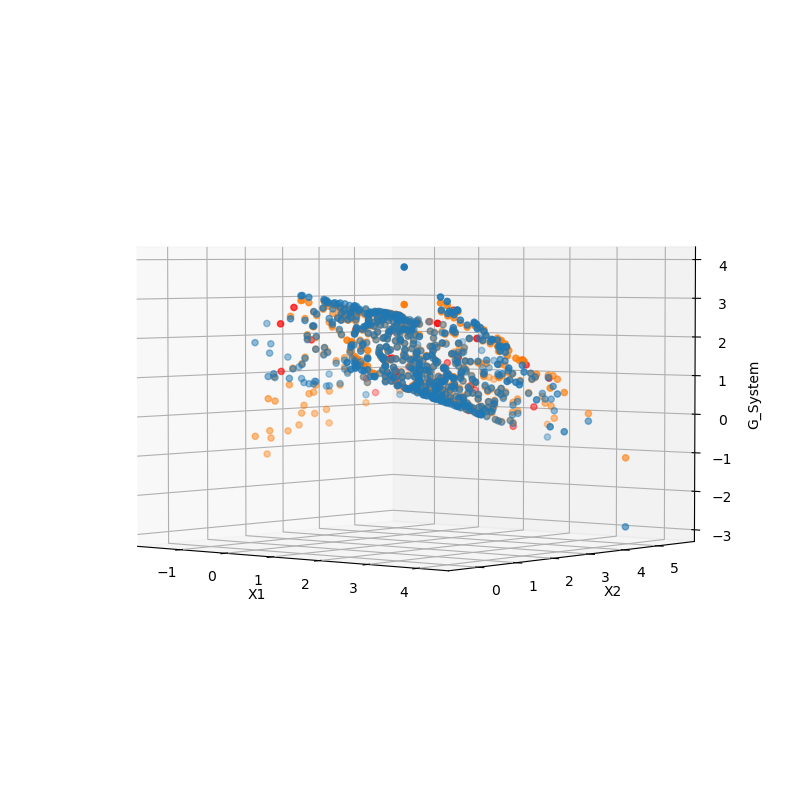

Text(0.5, 0, 'G_System')

In [102]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN)
ax.scatter(XR[:,0],XR[:,1], mean1)
ax.scatter(xr[:,0],xr[:,1], yn, color='red')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('G_System')

In [103]:
n_samples = 1e4

MCinputs_norm = np.zeros((int(n_samples), dim))
MCinputs = np.zeros((int(n_samples), dim))


MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(n_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(n_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

#model eval --------------------------------------------
gsyst = function(MCinputs)   
ymc = gsyst[0]
fail_samples = np.sum(ymc < 0 )
fail_prob = fail_samples/n_samples

#surrogate pred -----------------------------------------
mean_MCS = []
# var_MCS = []

for i in range (0, int(n_samples)):
    mean_,var_ = PCK1.predict(MCinputs_norm[i].reshape(1,-1))
    mean_MCS.append(mean_.tolist())
#     var_MCS.append(var_.tolist())

fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
fail_prob_SUMO = fail_samples_SUMO / n_samples

# Solution (Pf= 3.13E-2)

In [106]:
fail_prob, fail_prob_SUMO

(0.0295, 0.0312)

In [8]:
%%time
#predictions over a grid (for plotting)--------------------------------------------------

X1t,X2t = np.meshgrid(np.sort(XN[:,0]), np.sort(XN[:,1])) #grid over normalized points
Xt=np.stack((X1t,X2t),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

X1m,X2m = np.meshgrid(np.sort(XR[:,0]), np.sort(XR[:,1])) #grid over non-normalized points
Xtm=np.stack((X1m,X2m),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

yt=function(Xtm)    #test points
Mtest=yt[0]

response1=PCK_predict(Xt,xn,y,theta,modelpar1)   #model predictions over (ntest x ntest) points
mean1=response1[0]
var1=response1[1]


Wall time: 32.9 s


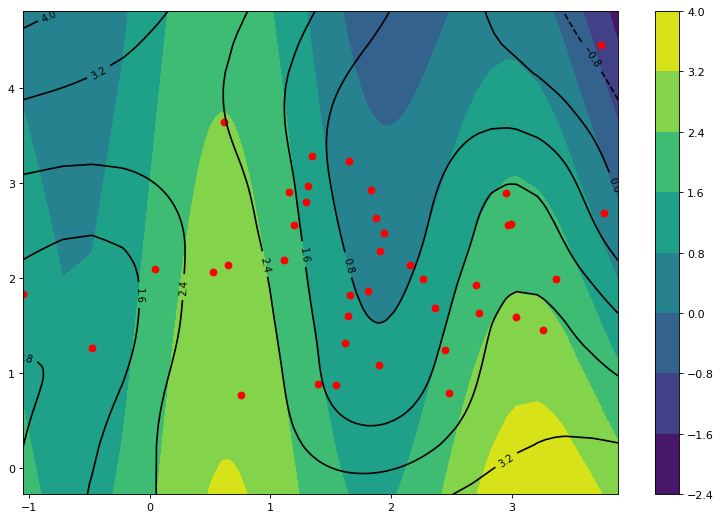

In [9]:
fig =plt.subplots(figsize=(12, 8), dpi=80)

levels = 7
cs = plt.contourf(np.sort(XR[:,0]), np.sort(XR[:,1]), Mtest.reshape(ntest,-1), levels)
cbar=plt.colorbar(cs)

csm = plt.contour(np.sort(XR[:,0]), np.sort(XR[:,1]), mean1.reshape(ntest,-1) ,levels, colors='k')
plt.clabel(csm, fontsize=9, inline=1)

plt.scatter(xr[:,0],xr[:,1],color='red')

cs.changed()

# LeaveOneOut_CrossValidation

In [ ]:
PC_loo=np.zeros(n)
KrigMeanloo=np.zeros(n)
KrigVarloo=np.zeros(n)
PC_looALL=np.zeros((n,ntest))
KrigMeanlooALL=np.zeros((n,ntest))
KrigVarlooALL=np.zeros((n,ntest))

#Generating PCK models for each reduced design of experiments 
for i in range (0,n):             
    y_loo=np.delete(y,[i])                              #y_n-i     leaving element i out the observations (M)
    xr_loo=np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the hermite inputs (xi)
    xn_loo=np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the inputs (xi)

    #Sampling matrix (A matrix) evaluation of the samples in a sparse p polynomials matrix from PCE
   
    A1_loo = np.zeros((n-1, p+1))
    A2_loo = np.zeros((n-1, p+1))
    phi_loo = np.zeros((n-1, len(alpha)))
    
    #generation of all orthogonal polynomials with degree smaller than p for each variable

    for j in range (0,n-1):
        for k in range (0,p+1):
            A1_loo[j,k] = np.array([M1(xn[j,0],k)])    #legendre

    for j in range (0,n-1):
        for k in range (0,p+1):
            A2_loo[j,k] = np.array([M2(xn[j,1],k)])    #hermite
    #-------------------------------------------------------------------------
    #Learning coefficients by Least-Square Minimization
    
    for j in range (0,n-1):
        for k in range (0,len(alpha)):
            phi_loo[j,k]=A1[j,alpha[k,0]]*A2[j,alpha[k,1]]  

    phi_tr_loo=phi_loo.transpose()
    phi_Inv_loo=np.linalg.inv(np.matmul(phi_tr_loo, phi_loo))
    Inv_phi_trans_loo=np.matmul(phi_Inv_loo,phi_tr_loo)
    Y_loo=np.matmul(Inv_phi_trans_loo,y_loo)     #coefficients for PC =f(M) observations
            
    # PCE mean prediction --------------leaving i-term out
    PC_loo[i] = PCE(xn[i,0],xn[i,1],alpha,Y_loo)       #Predictions on single i-point out following coefficients LOO
    PC_looALL[i] = PCE(X1,X2,alpha,Y_loo)              #Predictions on ALL test points following coefficients LOO
    
    # KRIGING mean--------------leaving i-term out
    [KrigMeanloo[i],KrigVarloo[i]]=GaussianPred(xr[i].reshape(-1,dim),xr_loo,y_loo,phi_loo,Y_loo,l,sig)    #Predictions on single i-point out following coefficients LOO
    [KrigMeanlooALL[i],KrigVarlooALL[i]]=GaussianPred(XR,xr_loo,y_loo,phi_loo,Y_loo,l,sig)                      #Predictions on ALL test points following coefficients LOO
    
mean_loo=PC_loo+KrigMeanloo
# e_loo=(M-mean_loo)**2
# sumat=np.divide(e_loo,KrigVarloo)
mean_looALL=PC_looALL+KrigMeanlooALL

# LOOCV=np.zeros(predict)
# cell=np.zeros(predict)
# for k in range (0,predict):  
#     voro = VoronoiCell(t2[k],xn)
#     LOOCV[k]= variaDiag[k]*(1+sumat[voro])
# #     cell[k] = voro